<h1>human organ classification </h1>
<h2> C-NN model<h3> [transfer learn on MobileNetV2 model]</h3></h2>

call to packages & libraries

In [1]:

from tensorflow import keras
from datetime import datetime

from src.sup.evaluation import *
from src.sup.support import *
from src.sup.test_set_eval import *

from tensorflow.keras.optimizers import RMSprop,SGD,Adam
from tensorflow.keras.layers import Dense,BatchNormalization,Dropout
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model

In [2]:
model_name = "mobileNet_v2_transfer_learn_2.3"

# Load the TensorBoard notebook extension.
%load_ext tensorboard

# call inline plt.

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/

callout dataset

In [3]:
classes = ['Heart','Brain','Eye','Kidney','Skeleton','Other']
root_dir = '../../datasets/'
train_dir = os.path.join(root_dir,'train/')
validation_dir = os.path.join(root_dir,'validation/')
tr_heart_dir,tr_brain_dir,tr_eye_dir,tr_kidney_dir,tr_skull_dir,tr_other_dir = path_update(train_dir,classes)
vl_heart_dir,vl_brain_dir,vl_eye_dir,vl_kidney_dir,vl_skull_dir,vl_other_dir = path_update(validation_dir,classes)

take a glance at training dataset

FileNotFoundError: [Errno 2] No such file or directory: '10.jpg'

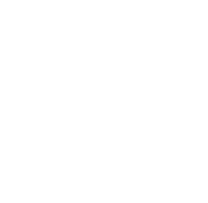

In [4]:
plot_sample_of_img(4,4,os.listdir(tr_heart_dir)+os.listdir(tr_eye_dir))

ImageGenator - autolabelling, and categorizing.

In [4]:
train_gen_tmp = ImageDataGenerator(rescale=1./255,
      width_shift_range=0.2,
      height_shift_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_gen_tmp = ImageDataGenerator(rescale=1/225.)
train_gen = train_gen_tmp.flow_from_directory(train_dir,
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size= 20,
                                              shuffle=True,
                                              seed=42)

validation_gen = validation_gen_tmp.flow_from_directory(validation_dir,
                                              target_size=(224,224),
                                              color_mode='rgb',
                                              class_mode='categorical',
                                              batch_size= 20,
                                              shuffle=True,
                                              seed=42)

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_gen.n//validation_gen.batch_size

clToInt_dict = train_gen.class_indices
clToInt_dict = dict((k,v) for v,k in clToInt_dict.items())

Found 2184 images belonging to 6 classes.
Found 185 images belonging to 6 classes.


define the model

In [5]:
weight_path = '../../h5_files/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_224.h5'

pre_model = MobileNetV2(input_shape=(224,224,3),
                    weights = None,
                    include_top = True)

pre_model.load_weights(weight_path)
#model.summary()

for layer in pre_model.layers:
    layer.trainable = False

conn_layer = pre_model.get_layer('block_12_add')
conn_output = conn_layer.output

x = Conv2D(128,(3,3),activation='relu')(conn_output)
x = MaxPool2D(2,2)(x)
x = Conv2D(256,(3,3),activation='relu')(x)
x = MaxPool2D(2,2)(x)
x = Flatten()(x)
#x = Dense(256,activation='relu')(x)
#x = Dropout(0.2)(x)
x = Dense(128,activation='relu')(x)
#x = Dropout(0.2)(x)
#x = BatchNormalization()(x)
x = Dense(6,activation='softmax')(x)

model = Model(pre_model.input,x)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
______________________________________________________________________________________________

compile the model

In [6]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

save the log

In [7]:
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")+'/'

if not os.path.exists(logdir):
    os.mkdir(logdir)

#print(datetime.now().strftime("%Y%m%d%H%M%S"))
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir, histogram_freq=1, profile_batch = 100000000)

fit & train the model.

In [8]:
history = model.fit(train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=14,
                    verbose=1,
                    callbacks= [tensorboard_callback])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 109 steps, validate for 9 steps
Epoch 1/14
109/109 [==============================] - 69s 629ms/step - loss: 1.7324 - accuracy: 0.6548 - val_loss: 0.2391 - val_accuracy: 0.9111

visualize layer process in cnn

In [11]:
#visualize_model(model,validation_dir+'/Brain/20.jpg')
#!mkdir -p saved_model
model.save('saved_model/my_model/')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


instant evaluation

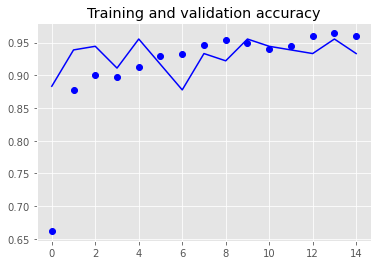

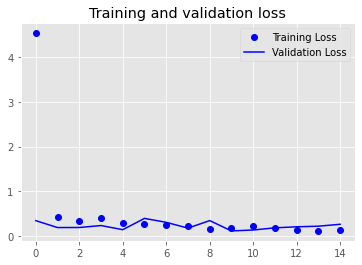

In [9]:
#call to the tensorboard
#%tensorboard --logdir ./logs/fit/
#look at training model performance
acc_n_loss(history)

#model.evaluate_generator(validation_gen,
#                         steps=STEP_SIZE_VALID)

evaluate the model on test set.


In [ ]:
model_path = '../../h5_files/models/20200829133245mobileNet_v2_transfer_learn_2.2.h5'
model_weight_path = '../../h5_files/weights/20200829133245mobileNet_v2_transfer_learn_2.2.h5'

model = load_model(model_path)
model.load_weights(model_weight_path)
y_pred,y_test = test_eval(model)
plot_confusion_metrix(y_test,y_pred,classes)
ROC_classes(6,y_test,y_pred,classes)



 save the model in .h5 file

In [10]:
model_path,model_weight_path = save(model,datetime.now().strftime("%Y%m%d%H%M%S")+model_name+'.h5')

make prediction on random images

In [ ]:
model_path = '../../h5_files/models/20200829133245mobileNet_v2_transfer_learn_2.2.h5'
model_weight_path = '../../h5_files/weights/20200829133245mobileNet_v2_transfer_learn_2.2.h5'
img_path = '../../datasets/validation/../../datasets/validation/Brain/Capture.jpg'
#rnd_predict(model_path,model_weight_path,img_path,clToInt_dict)
visualize_model(model_path,model_weight_path,img_path)

Found 185 images belonging to 6 classes.
Instructions for updating:
Please use Model.predict, which supports generators.
10/10 [==============================] - 1s 142ms/step


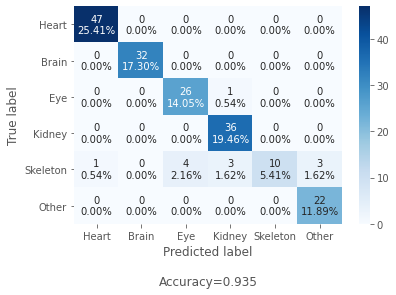

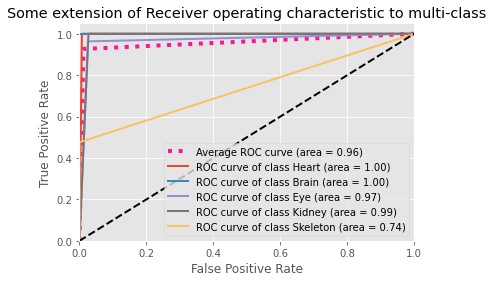

In [12]:
preds,testy = test_eval(model)
plot_confusion_metrix(testy,preds,classes)
ROC_classes(5,testy,preds,classes)

In [9]:
from io import BytesIO
import dill,base64,tempfile

In [10]:
#Saving Model as base64
model_json = model.to_json()

def Base64Converter(ObjectFile):
    bytes_container = BytesIO()
    dill.dump(ObjectFile, bytes_container)
    bytes_container.seek(0)
    bytes_file = bytes_container.read()
    base64File = base64.b64encode(bytes_file)
    return base64File

base64KModelJson = Base64Converter(model_json)

In [11]:
import joblib

In [12]:
joblib.dump(base64KModelJson,'../../h5_files/models/model.bytes')

['../../h5_files/models/model.bytes']